### VCM Research

### Difference-in-Differences


In [5]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import random 

In [19]:
# specify the file path and filename
file_path = '/Users/f/Desktop/VCM_IS-R_C.csv'

# use the read_csv function to open the file and store the data in a data frame
df = pd.read_csv(file_path, low_memory=False)

# Select the columns you want to melt
columns_to_melt = [str(i) for i in range(2004, 2022)]

# Melt the selected columns, using the column names as the id_vars
df = pd.melt(df, id_vars=['Project ID', 'Voluntary Registry', 'Voluntary Status', 'Scope', 'Type', 'Country', 'Total Credits \nIssued'], 
             value_vars=columns_to_melt, var_name='years', value_name='surplus').dropna()

# Convert years to numeric
df['years'] = pd.to_numeric(df['years'])

# Convert surplus to numeric
df['surplus'] = pd.to_numeric(df['surplus'])

df

,Project ID,Voluntary Registry,Voluntary Status,Scope,Type,Country,Total Credits \nIssued,years,surplus
0,ACR102,ACR,Completed,Chemical Processes,Reduction,United States,7984006,2004,0
1,ACR103,ACR,Completed,Agriculture,Reduction,United States,44202,2004,0
2,ACR106,ACR,Completed,Waste Management,Reduction,United States,138492,2004,0
3,ACR107,ACR,Completed,Industrial Manufacturing,Reduction,Bolivia,1138,2004,0
4,ACR109,ACR,Registered,Industrial Manufacturing,Reduction,United States,541804,2004,0
...,...,...,...,...,...,...,...,...,...
102991,VCS997,VCS,Registered,Renewable Energy,Reduction,China,0,2021,0
102992,VCS998,VCS,Registered,Household & Community,Reduction,Vietnam,32897,2021,0
102993,VCS999,VCS,Under validation,Forestry & Land Use,Mixed,Bolivia,0,2021,0
102994,VCSOPR10,VCS,Transfer to another GHG program,Forestry & Land Use,Mixed,United States,97193,2021,0


In [20]:
# Specify the treatment group
treatment_group = ['Switzerland', 'Belize', 'Spain', 'Costa Rica', 'Paraguay', 
                   'New Zealand', 'Germany', 'United Kingdom', 'Colombia', 'Fiji']

# Create treatment and post_treatment columns
df['treatment'] = df['Country'].isin(treatment_group).astype(int)
df['post_treatment'] = (df['years'] >= 2018).astype(int)

# Fit the model using the ols function from the statsmodels library
model = smf.ols(formula = 'surplus ~ treatment + post_treatment + treatment*post_treatment', data = df).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     31.25
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           3.52e-20
Time:                        13:38:35   Log-Likelihood:            -1.3825e+06
No. Observations:              102996   AIC:                         2.765e+06
Df Residuals:                  102992   BIC:                         2.765e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

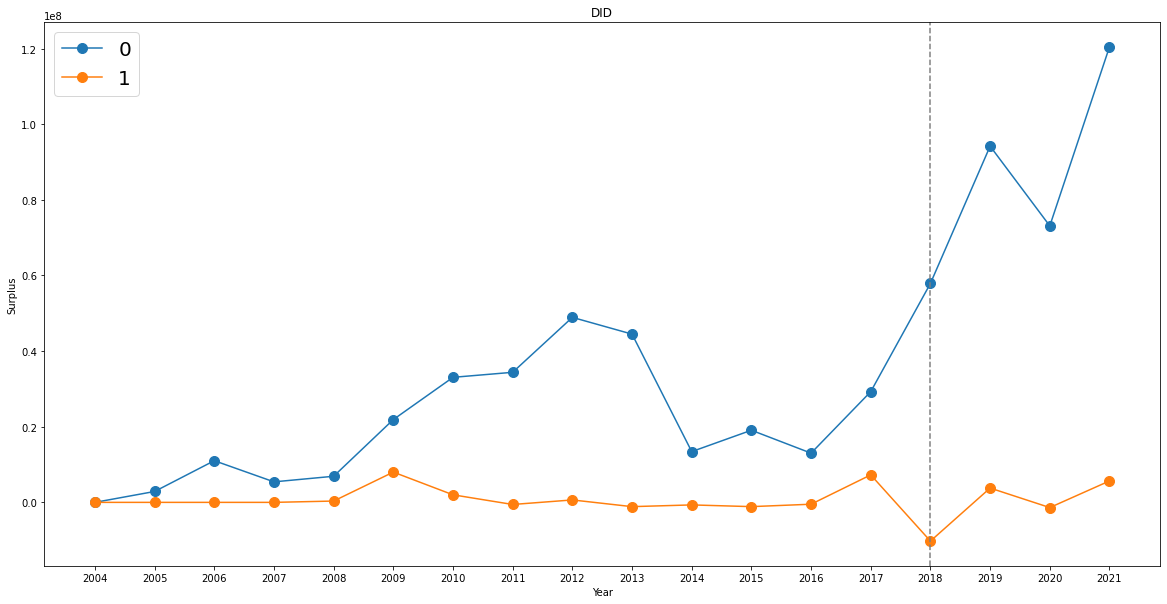

In [61]:
# Create a pivot table to summarize the surplus by year and treatment
ax = df.pivot_table(values='surplus', index='years', columns='treatment', aggfunc='sum').plot(
    # Set the figure size
    figsize=(20, 10),
    # Set the marker style and size
    marker='.', 
    markersize=20, 
    # Set the title of the plot
    title='DID',
    # Set the x-axis label
    xlabel='Year',
    # Set the y-axis label
    ylabel='Surplus',
    # Set the x-axis ticks to match the years in the dataframe
    xticks=df['years'].drop_duplicates().sort_values().astype('int')
)

# Add a vertical line to show the year of the policy change
ax.axvline(x=2018, color='gray', linestyle='--')
ax.legend(fontsize=20)

### Placebo test 

In [58]:
# set the seed for reproducibility
random.seed(1)

# create a list of countries that are not in the treatment group
countries = list(set(countries for countries in df["Country"] if countries not in treatment_group))

# select a random sample of countries from the list of non-treatment countries 
# that has the same number of elements as the treatment group
placebo_group = random.sample(countries, len(treatment_group))

# create a new column in the dataframe indicating whether each country is in the placebo group
df['placebo_treatment'] = df['Country'].isin(placebo_group).astype(int)

# create a new column indicating whether the observation is post-treatment
df['post_placebo_treatment'] = (df['years'] >= 2018).astype(int)

# Fit the model using the ols function from the statsmodels library
# The formula specifies the response variable and the predictor variables
# The data parameter specifies the dataframe to use
model = smf.ols(formula = 'surplus ~ placebo_treatment + post_placebo_treatment + placebo_treatment*post_placebo_treatment', data = df).fit()

# Print the summary of the model
print(model.summary())
                               

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     29.12
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           8.24e-19
Time:                        13:53:02   Log-Likelihood:            -1.3825e+06
No. Observations:              102996   AIC:                         2.765e+06
Df Residuals:                  102992   BIC:                         2.765e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

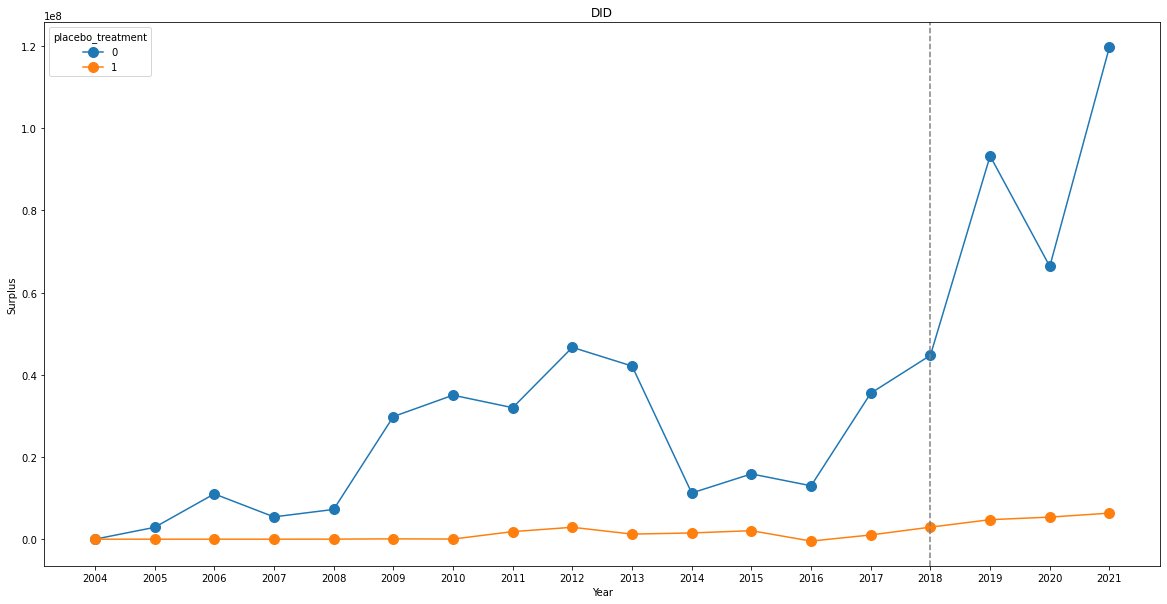

In [62]:
ax = df.pivot_table(values='surplus', index='years', columns='placebo_treatment', aggfunc='sum').plot(
    figsize=(20, 10),
    marker='.', 
    markersize=20, 
    title='DID',
    xlabel='Year',
    ylabel='Surplus',
    # to make sure each year is displayed on axis
    xticks=df['years'].drop_duplicates().sort_values().astype('int')
)

ax.axvline(x=2018, color='gray', linestyle='--')